# Probabilistic Latent Semantic Indexing (PLSI) for Speech Denoising 

## 1. Convert the two training signals trs.wav and trn.wav using the earlier STFT setup you used in the previous homework. Let’s call these complex-valued matrices S and N.

WAV file:  Fs = 16000, trs.shape = (456707,), trs.dtype = float32


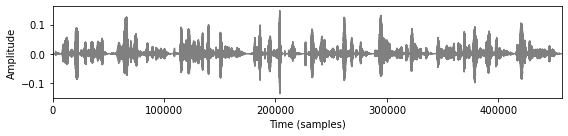

In [20]:
trs , Fs1 = librosa.load("data/trs.wav", sr = None)
print('%s Fs = %d, trs.shape = %s, trs.dtype = %s' % ('WAV file: ', Fs1, trs.shape, trs.dtype))
plt.figure(figsize=(8, 2))
plt.plot(trs, color='gray')
plt.xlim([0, trs.shape[0]])
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()
ipd.display(ipd.Audio(data=trs, rate=Fs1))

WAV file:  Fs = 16000, trn.shape = (456707,), trn.dtype = float32


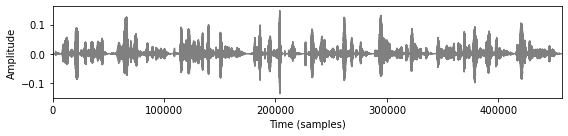

In [21]:
trn , Fs2 = librosa.load("data/trn.wav", sr = None)
print('%s Fs = %d, trn.shape = %s, trn.dtype = %s' % ('WAV file: ', Fs2, trn.shape, trn.dtype))
plt.figure(figsize=(8, 2))
plt.plot(trs, color='gray')
plt.xlim([0, trn.shape[0]])
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()
ipd.display(ipd.Audio(data=trn, rate=Fs2))

In [22]:
def get_stft(x):
    return stft(x, n_fft=1024, hop_length=512, win_length=1024, window='hann', center=True)

def get_istft(x):
    return librosa.istft(x, hop_length=512, center=True)

In [23]:
S = get_stft(trs)
S.shape

(513, 893)

In [24]:
N = get_stft(trn)
N.shape

(513, 893)

## 2. Build a speech denoising system by using the PLSI algorithm. The overall procedure is described in M11-S33. The update rules are on M11-S18 (use the ones on the top of the slide, not the NMF ones).

In [25]:
def calc_B(B, T, M):
    x = np.divide(np.abs(M),(np.matmul(B,T) + 0.0000000001))
    y = np.matmul(x, T.T)
    z = np.ones(shape=(M.shape[0], M.shape[0]))
    
    B = np.multiply(B, y)
    B = np.divide(B, (np.matmul(z, B) + 0.0000000001))
    return B

In [26]:
def calc_T(B, T, M, K):
    x = np.divide(np.abs(M),(np.matmul(B,T) + 0.0000000001))
    y = np.matmul(B.T,x)
    T = np.multiply(T, y)
    z = np.ones(shape=(K, K))
    T = np.divide(T, (np.matmul(z, T) + 0.0000000001))
    return T

## 3. First, run your PLSI algorithm to learn B(1) from |S| (the magnitudes). 

## 4. Second, run your PLSI algorithm to learn B(2) from |N|.

In [27]:
Ks, Kn = 30, 30

B1 = np.random.rand(S.shape[0], Ks)
B2 = np.random.rand(S.shape[0], Kn)

T1 = np.random.rand(Ks, S.shape[1])
T2 = np.random.rand(Kn, S.shape[1])

for i in range(500):
    B1 = calc_B(B1, T1, S)
    T1 = calc_T(B1, T1, S, Ks)
    
    B2 = calc_B(B2, T2, N)
    T2 = calc_T(B2, T2, N, Kn)

In [28]:
print("Shape of T1:", T1.shape)
print("Shape of T2:", T2.shape)

Shape of T1: (30, 893)
Shape of T2: (30, 893)


## 5. Third, load your test mixture tex.wav and turn it into a spectrogram X. Run your third PLSI routine here to learn Θ(3) by taking the magnitudes |X|. Remember, you don’t want to update B(1) and B(2) during testing. You just initialize them from the ones you trained.

WAV file:  Fs = 16000, tex.shape = (81920,), tex.dtype = float32


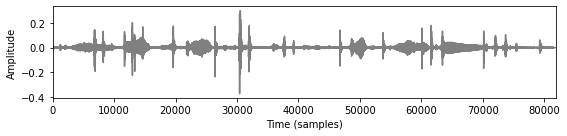

In [29]:
tex , Fs3 = librosa.load("data/tex.wav", sr = None)
print('%s Fs = %d, tex.shape = %s, tex.dtype = %s' % ('WAV file: ', Fs3, tex.shape, tex.dtype))
plt.figure(figsize=(8, 2))
plt.plot(tex, color='gray')
plt.xlim([0, tex.shape[0]])
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()
ipd.display(ipd.Audio(data=tex, rate=Fs3))

## 6. You know, the speech source can be first recovered by doing B(1)Θ(3) , where Ks is the 1:Ks ,: number of basis vectors in B(1). It means that you need to pick your own choice of Ks and Kn during training.

In [30]:
X = get_stft(tex)
X.shape

(513, 161)

In [31]:
B3 = np.hstack((B1,B2))
T3 = np.concatenate((T1[:,:161],T2[:,:161]),axis=0)
Ksn = Ks+Kn

print(B3.shape)

(513, 60)


In [32]:
for i in range(500):
    T3 = calc_T(B3, T3, X, Ksn)
print(T3.shape)

(60, 161)


## 7. However, B(1)Θ(3) will only give you the “probability matrix” of the speech source, not 1:Ks ,: the actual spectrogram. Hence, you need to turn it into some kind of TF-bin-wise posterior probability (of belonging to the speech source) and use it as a mask:

WAV file:  Fs = 16000, tes.shape = (81920,), tes.dtype = float32


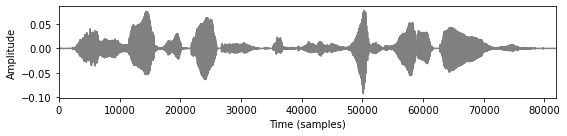

In [33]:
tes , Fs4 = librosa.load("data/tes.wav", sr = None)
Y = get_stft(tes)

print('%s Fs = %d, tes.shape = %s, tes.dtype = %s' % ('WAV file: ', Fs4, tes.shape, tes.dtype))
plt.figure(figsize=(8, 2))
plt.plot(tes, color='gray')
plt.xlim([0, tes.shape[0]])
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()
ipd.display(ipd.Audio(data=tes, rate=Fs4))

## 8. Transform Sˆtest back to the time domain.

WAV file:  Fs = 16000, S_final.shape = (81920,), S_final.dtype = float64


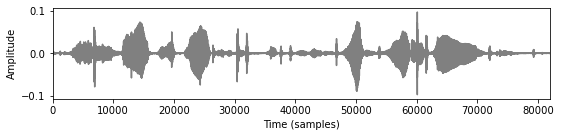

In [34]:
S_test = np.multiply(np.divide(np.matmul(B1,T3[:Ks,:]),(np.matmul(B3, T3)+0.0000000001)), X)
S_final = get_istft(S_test)

print('%s Fs = %d, S_final.shape = %s, S_final.dtype = %s' % ('WAV file: ', Fs3, S_final.shape, S_final.dtype))
plt.figure(figsize=(8, 2))
plt.plot(S_final, color='gray')
plt.xlim([0, S_final.shape[0]])
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()
ipd.display(ipd.Audio(data = S_final, rate=Fs3))

## 9. Report the SNR value of the separation result by comparing sˆtest to tes.wav.

In [35]:
def calc_SNR(original, recovered):
    diff = original - recovered
    SNR = 10 * np.log10(np.dot(original.T, original)/np.dot(diff.T, diff))
    return SNR

In [36]:
SNR = calc_SNR(tes, S_final)
print("SNR:", SNR)

SNR: 10.768188695014908


## 10. Plug in the recovered speech to the notebook with a player (so that the AI can listen to it).

In [37]:
print("Recovered Audio")
ipd.display(ipd.Audio(data = S_final, rate=Fs3))
print("Test Audio")
ipd.display(ipd.Audio(data=tes, rate=Fs4))

Recovered Audio


Test Audio


In [ ]:
# P2: Probabilistic Latent Semantic Indexing (PLSI) for Speech Denoising [5 points]

## 1. Convert the two training signals trs.wav and trn.wav using the earlier STFT setup you used in the previous homework. Let’s call these complex-valued matrices S and N.

trs , Fs1 = librosa.load("data/trs.wav", sr = None)
print('%s Fs = %d, trs.shape = %s, trs.dtype = %s' % ('WAV file: ', Fs1, trs.shape, trs.dtype))
plt.figure(figsize=(8, 2))
plt.plot(trs, color='gray')
plt.xlim([0, trs.shape[0]])
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()
ipd.display(ipd.Audio(data=trs, rate=Fs1))

trn , Fs2 = librosa.load("data/trn.wav", sr = None)
print('%s Fs = %d, trn.shape = %s, trn.dtype = %s' % ('WAV file: ', Fs2, trn.shape, trn.dtype))
plt.figure(figsize=(8, 2))
plt.plot(trs, color='gray')
plt.xlim([0, trn.shape[0]])
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()
ipd.display(ipd.Audio(data=trn, rate=Fs2))

def get_stft(x):
    return stft(x, n_fft=1024, hop_length=512, win_length=1024, window='hann', center=True)

def get_istft(x):
    return librosa.istft(x, hop_length=512, center=True)

S = get_stft(trs)
S.shape

N = get_stft(trn)
N.shape

## 2. Build a speech denoising system by using the PLSI algorithm. The overall procedure is described in M11-S33. The update rules are on M11-S18 (use the ones on the top of the slide, not the NMF ones).

def calc_B(B, T, M):
    x = np.divide(np.abs(M),(np.matmul(B,T) + 0.0000000001))
    y = np.matmul(x, T.T)
    z = np.ones(shape=(M.shape[0], M.shape[0]))
    
    B = np.multiply(B, y)
    B = np.divide(B, (np.matmul(z, B) + 0.0000000001))
    return B

def calc_T(B, T, M, K):
    x = np.divide(np.abs(M),(np.matmul(B,T) + 0.0000000001))
    y = np.matmul(B.T,x)
    T = np.multiply(T, y)
    z = np.ones(shape=(K, K))
    T = np.divide(T, (np.matmul(z, T) + 0.0000000001))
    return T

## 3. First, run your PLSI algorithm to learn B(1) from |S| (the magnitudes). 

## 4. Second, run your PLSI algorithm to learn B(2) from |N|.

Ks, Kn = 30, 30

B1 = np.random.rand(S.shape[0], Ks)
B2 = np.random.rand(S.shape[0], Kn)

T1 = np.random.rand(Ks, S.shape[1])
T2 = np.random.rand(Kn, S.shape[1])

for i in range(500):
    B1 = calc_B(B1, T1, S)
    T1 = calc_T(B1, T1, S, Ks)
    
    B2 = calc_B(B2, T2, N)
    T2 = calc_T(B2, T2, N, Kn)

print("Shape of T1:", T1.shape)
print("Shape of T2:", T2.shape)

## 5. Third, load your test mixture tex.wav and turn it into a spectrogram X. Run your third PLSI routine here to learn Θ(3) by taking the magnitudes |X|. Remember, you don’t want to update B(1) and B(2) during testing. You just initialize them from the ones you trained.

tex , Fs3 = librosa.load("data/tex.wav", sr = None)
print('%s Fs = %d, tex.shape = %s, tex.dtype = %s' % ('WAV file: ', Fs3, tex.shape, tex.dtype))
plt.figure(figsize=(8, 2))
plt.plot(tex, color='gray')
plt.xlim([0, tex.shape[0]])
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()
ipd.display(ipd.Audio(data=tex, rate=Fs3))

## 6. You know, the speech source can be first recovered by doing B(1)Θ(3) , where Ks is the 1:Ks ,: number of basis vectors in B(1). It means that you need to pick your own choice of Ks and Kn during training.

X = get_stft(tex)
X.shape

B3 = np.hstack((B1,B2))
T3 = np.concatenate((T1[:,:161],T2[:,:161]),axis=0)
Ksn = Ks+Kn

print(B3.shape)

for i in range(500):
    T3 = calc_T(B3, T3, X, Ksn)
print(T3.shape)

## 7. However, B(1)Θ(3) will only give you the “probability matrix” of the speech source, not 1:Ks ,: the actual spectrogram. Hence, you need to turn it into some kind of TF-bin-wise posterior probability (of belonging to the speech source) and use it as a mask:

tes , Fs4 = librosa.load("data/tes.wav", sr = None)
Y = get_stft(tes)

print('%s Fs = %d, tes.shape = %s, tes.dtype = %s' % ('WAV file: ', Fs4, tes.shape, tes.dtype))
plt.figure(figsize=(8, 2))
plt.plot(tes, color='gray')
plt.xlim([0, tes.shape[0]])
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()
ipd.display(ipd.Audio(data=tes, rate=Fs4))

## 8. Transform Sˆtest back to the time domain.

S_test = np.multiply(np.divide(np.matmul(B1,T3[:Ks,:]),(np.matmul(B3, T3)+0.0000000001)), X)
S_final = get_istft(S_test)

print('%s Fs = %d, S_final.shape = %s, S_final.dtype = %s' % ('WAV file: ', Fs3, S_final.shape, S_final.dtype))
plt.figure(figsize=(8, 2))
plt.plot(S_final, color='gray')
plt.xlim([0, S_final.shape[0]])
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()
ipd.display(ipd.Audio(data = S_final, rate=Fs3))

## 9. Report the SNR value of the separation result by comparing sˆtest to tes.wav.

def calc_SNR(original, recovered):
    diff = original - recovered
    SNR = 10 * np.log10(np.dot(original.T, original)/np.dot(diff.T, diff))
    return SNR

SNR = calc_SNR(tes, S_final)
print("SNR:", SNR)

## 10. Plug in the recovered speech to the notebook with a player (so that the AI can listen to it).

print("Recovered Audio")
ipd.display(ipd.Audio(data = S_final, rate=Fs3))
print("Test Audio")
ipd.display(ipd.Audio(data=tes, rate=Fs4))